In [1]:
import numpy as np
import random
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pysmt.shortcuts import Symbol, And, Real, LT, GT, Max, Plus, get_model
from pysmt.typing import REAL

In [2]:
class Model(nn.Module):
    def __init__(self, embedding_size):
        super(Model, self).__init__()             
        self.linear0 = nn.Linear(3, embedding_size)
        self.linear1 = nn.Linear(embedding_size, 2)
        self.linear_layers = [self.linear0, self.linear1]
        self.relu = nn.ReLU()
        
    def forward(self, x):   
        x = self.linear0(x)
        x = self.relu(x)  
        
        x = self.linear1(x)
        
        return x

In [3]:
def train_backpropagation(model, all_data, labels, criterion, optimizer, num_epochs):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        num_correct = 0
    
        for (data, label) in zip(all_data, labels): 
            optimizer.zero_grad()
        
            output = model(data)
            prediction = torch.argmax(output.data)

            loss = criterion(output, label)
            num_correct += (label == prediction)
        
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

        loss = running_loss/len(labels)
        accuracy = num_correct/len(labels)
        print("epoch: " + str(epoch) + ", accuracy: " + str(accuracy.item()) + ", loss: " + str(loss))
        
        if (accuracy == 1.0):
            return

In [4]:
def train_smt(model, all_data, labels):
    
    layers_weights = []
    num_layers = len(model.linear_layers)
    for i in range(num_layers):
        num_rows = len(model.linear_layers[i].weight.data)
        num_cols = len(model.linear_layers[i].weight.data[0])
        layer_weights = []
        for j in range(num_rows):
            weights = []
            for k in range(num_cols):
                weights.append(Symbol("weight_" + str(i) + "_" + str(j) + "_" + str(k), REAL))
            weights.append(Symbol(str("bias_" + str(i) + "_" + str(j)), REAL))
            layer_weights.append(weights)
        layers_weights.append(layer_weights)

    equations = []
    for (data, label) in zip(all_data, labels):
        x = []
        for value in data:
            x.append(Real(value.item()))
            
        for i in range(num_layers):
            num_rows = len(model.linear_layers[i].weight.data)
            num_cols = len(model.linear_layers[i].weight.data[0])
            new_x = []
            for j in range(num_rows):
                calculations = []
                for k in range(num_cols):
                    calculation = layers_weights[i][j][k] * x[k]
                    calculations.append(calculation)
                calculations.append(layers_weights[i][j][num_cols])
                output = Plus(calculations)
                if i < num_layers-1:
                    output = Max(output, Real(0.0))
                new_x.append(output)
            x = new_x
    
        if label.item() == 0:
            equation = GT(x[0], x[1])
        else:
            equation = LT(x[0], x[1])
            
        equations.append(equation)

    formula = And(equations)
    solution = get_model(formula)
    
    if solution:
        for i in range(num_layers):
            num_rows = len(model.linear_layers[i].weight.data)
            num_cols = len(model.linear_layers[i].weight.data[0])
            for j in range(num_rows):
                for k in range(num_cols):
                    weight = layers_weights[i][j][k]
                    weight_solution = solution[weight].constant_value()
                    model.linear_layers[i].weight.data[j][k] = float(weight_solution)
    
                bias = layers_weights[i][j][num_cols]
                bias_solution = solution[bias].constant_value()
                model.linear_layers[i].bias.data[j] = float(bias_solution)

    else:
        print("No solution found")

In [5]:
def test(model, all_data, labels, criterion): 
    running_loss = 0.0
    num_correct = 0
    
    for (data, label) in zip(all_data, labels): 
        output = model(data)
        prediction = torch.argmax(output.data)

        loss = criterion(output, label)
        num_correct += (label == prediction)
        
        running_loss += loss.item()

    loss = running_loss/len(labels)
    accuracy = num_correct/len(labels)
    
    print("testing accuracy: " + str(accuracy.item()) + " and loss: " + str(loss))

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

points = []
for i in range(0, 360, 60):
    for j in range(0, 180, 60):
        i_radians = (i * np.pi) / 180.0
        j_radians = (j * np.pi) / 180.0
        x = np.cos(i_radians) *  np.sin(j_radians)
        y = np.sin(i_radians) * np.sin(j_radians)
        z = np.cos(j_radians)
        points.append([x, y, z])
points = torch.FloatTensor(points)
print("points.shape: ", points.shape)

hyperplane = [random.uniform(0, 0.001), random.uniform(0, 0.001), random.uniform(0, 0.001)]
print("hyperplane: ", hyperplane)

labels = []
for point in points:
    if point[0] * hyperplane[0] + point[1] * hyperplane[1] + point[2] * hyperplane[2] > 0:
        labels.append(1)
    else:
        labels.append(0)

labels = torch.tensor(labels)

criterion = nn.CrossEntropyLoss()
num_epochs = 100

points.shape:  torch.Size([18, 3])
hyperplane:  [0.000818815622825853, 0.00011441805840998165, 0.0009621364917030963]


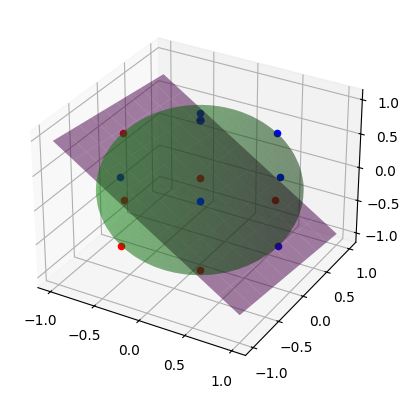

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plane_X, plane_Y = np.meshgrid(np.linspace(-1,1,10), np.linspace(-1,1,10))
plane_Z = (-hyperplane[0] * plane_X - hyperplane[1] * plane_Y) / hyperplane[2]

ax.plot_surface(plane_X, plane_Y, plane_Z, color='purple', alpha=0.5)

U, V = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
sphere_X = np.cos(U) * np.sin(V)
sphere_Y = np.sin(U) * np.sin(V)
sphere_Z = np.cos(V)

ax.plot_surface(sphere_X, sphere_Y, sphere_Z, color='green', alpha=0.3)

for (index, point) in enumerate(points):
    if labels[index] == 1:
        ax.scatter(point[0], point[1], point[2], color='blue', alpha = 1.0)
    else:
        ax.scatter(point[0], point[1], point[2], color='red', alpha = 1.0)

plt.show()

In [ ]:
embedding_sizes = [10, 20, 30, 40, 50, 60, 70, 80]
smt_times = []
backpropagation_times = []

for embedding_size in embedding_sizes:
    
    print("embedding_size: ", embedding_size)

    model = Model(embedding_size)
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
    model.to(device)

    start_time = time.time()
    train_backpropagation(model, points, labels, criterion, optimizer, num_epochs)
    backpropagation_times.append(time.time() - start_time)

    start_time = time.time()
    train_smt(model, points, labels)
    smt_times.append(time.time() - start_time)
    test(model, points, labels, criterion)

embedding_size:  10
epoch: 0, accuracy: 0.5555555820465088, loss: 0.6780294494496452
epoch: 1, accuracy: 0.7777777910232544, loss: 0.4857107061478827
epoch: 2, accuracy: 0.8888888955116272, loss: 0.3707762820025285
epoch: 3, accuracy: 0.8888888955116272, loss: 0.29741602597965133
epoch: 4, accuracy: 0.9444444179534912, loss: 0.252885006989042
epoch: 5, accuracy: 0.9444444179534912, loss: 0.22520549140042728
epoch: 6, accuracy: 0.8888888955116272, loss: 0.2055834287053181
epoch: 7, accuracy: 0.9444444179534912, loss: 0.18978664571315879
epoch: 8, accuracy: 1.0, loss: 0.17635367032037014
testing accuracy: 1.0 and loss: 0.2254862981951899
embedding_size:  20
epoch: 0, accuracy: 0.6666666865348816, loss: 0.6191189512610435
epoch: 1, accuracy: 0.7777777910232544, loss: 0.45053372407952946
epoch: 2, accuracy: 0.8888888955116272, loss: 0.3512596802579032
epoch: 3, accuracy: 0.8333333134651184, loss: 0.29177301646106774
epoch: 4, accuracy: 0.8888888955116272, loss: 0.25076727548407185
epoch: 5

In [ ]:
for i in range(len(embedding_sizes)):
    embedding_sizes[i] = 3 * embedding_sizes[i] + 2 * embedding_sizes[i]

In [ ]:
plt.scatter(embedding_sizes, smt_times)
plt.title("SMT Training Time")
plt.xlabel("Embedding Layer Size")
plt.ylabel("Running Time (secs)")
plt.show()

In [ ]:
plt.scatter(embedding_sizes, backpropagation_times)
plt.title("Backpropagation Training Time")
plt.xlabel("Embedding Layer Size")
plt.ylabel("Running Time (secs)")
plt.show()